## Final Project

In [1]:
import sympy as sp
import numpy as np
from scipy.linalg import expm
from scipy.io import loadmat
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# =======================
# Provided Nominal Values
# =======================

# State
xi_g_nom    = 10.0
eta_g_nom   = 0.0
theta_g_nom = float(sp.pi/2)
xi_a_nom    = -60.0
eta_a_nom   = 0.0
theta_a_nom = float(-sp.pi/2)
x_nom = np.array([
    xi_g_nom,
    eta_g_nom,
    theta_g_nom,
    xi_a_nom,
    eta_a_nom,
    theta_a_nom
], dtype=float)
n = x_nom.shape[0] # state dimensions

#Input
v_g_nom     = 2.0
phi_g_nom   = float(-sp.pi/18)
v_a_nom     = 12.0
omega_a_nom = float(sp.pi/25)
u_nom = np.array([
    v_g_nom,
    phi_g_nom,
    v_a_nom,
    omega_a_nom
], dtype=float)
m = u_nom.shape[0] # input dimensions

L_nom = 0.5


# ===========================
#        Setup Sympy
# ===========================

# State and Input
xi_g, eta_g, theta_g, xi_a, eta_a, theta_a = sp.symbols('xi_g eta_g theta_g xi_a eta_a theta_a', real=True)
v_g, phi_g, v_a, omega_a = sp.symbols('v_g phi_g v_a omega_a', real=True) 

# State and input vectors
x_sym = sp.Matrix([xi_g, eta_g, theta_g, xi_a, eta_a, theta_a])
u_sym = sp.Matrix([v_g, phi_g, v_a, omega_a])

# Parameters
L_sym = sp.symbols('L', positive=True)

# ===========================
#       Setup Dynamics
# ===========================

# State
f1 = v_g * sp.cos(theta_g)
f2 = v_g * sp.sin(theta_g)
f3 = (v_g / L_sym) * sp.tan(phi_g)
f4 = v_a * sp.cos(theta_a)
f5 = v_a * sp.sin(theta_a)
f6 = omega_a
f_sym = sp.Matrix([f1, f2, f3, f4, f5, f6])

# Measurements
delta_xi = xi_a - xi_g
delta_eta = eta_a - eta_g
h1 = sp.atan2(delta_eta, delta_xi) - theta_g # Azimuth of UAV from UGV, relative to UGV heading
h2 = sp.sqrt(delta_xi**2 + delta_eta**2) # Distance between UGV/UAV
h3 = sp.atan2(-delta_eta, -delta_xi) - theta_a # Azimuth of UGV from UAV, relative to UAV heading
h4 = xi_a # UAV easting position
h5 = eta_a # UAV northing position
h_sym = sp.Matrix([h1, h2, h3, h4, h5])
p = h_sym.shape[0] # measurement dimensions

# Symbolic Jacobians for A, B, C
A_sym = f_sym.jacobian(x_sym) # df/dx - 6x6
B_sym = f_sym.jacobian(u_sym) # df/du - 6x4
C_sym = h_sym.jacobian(x_sym) # dh/dx - 5x6

# ============================
# Define functions from Sympy
# ============================

A_eval = sp.lambdify(
    (x_sym, u_sym, L_sym),
    A_sym,
    "numpy"
)

B_eval = sp.lambdify(
    (x_sym, u_sym, L_sym),
    B_sym,
    "numpy"
)

C_eval = sp.lambdify(
    (x_sym,),
    C_sym,
    "numpy"
)

# Function that will evaluate our NL CT dynamics for given x and u
f_eval = sp.lambdify(
    (x_sym, u_sym, L_sym),
    f_sym,
    "numpy"
)

def f_ct(x_vec, u_vec, L_val=0.5):
    """
    Wrapper for f_eval sympy lambda.
    Computes continuous-time nonlinear dynamics xdot = f(x,u).

    x_vec: shape (6,) numpy array [xi_g, eta_g, theta_g, xi_a, eta_a, theta_a]
    u_vec: shape (4,) numpy array [v_g, phi_g, v_a, omega_a]
    L_val: scalar (e.g. 0.5)

    Returns: shape (6,) numpy array xdot
    """
    # Ensure 1D arrays
    x_vec = np.asarray(x_vec, dtype=float).reshape(-1)
    u_vec = np.asarray(u_vec, dtype=float).reshape(-1)

    xdot = f_eval(x_vec, u_vec, L_val) # this returns a 6x1-like object
    return np.array(xdot, dtype=float).reshape(6,)

h_eval = sp.lambdify(
    (x_sym,),
    h_sym,
    "numpy"
)

def h_meas(x_vec):
    """
    Wrapper for h_eval sympy lambda.
    linear measurement model y = h(x).

    x_vec: shape (6,) numpy array [xi_g, eta_g, theta_g, xi_a, eta_a, theta_a]

    Returns: shape (5,) numpy array y
    """
    x_vec = np.asarray(x_vec, dtype=float).reshape(-1)

    y = h_eval(x_vec)
    return np.array(y, dtype=float).reshape(5,)


# ===================================
# Evaluate at nominal operating point
# ===================================

# Get ready to sub back into our symbolic expressions
subs_nom = {
    xi_g: xi_g_nom,
    eta_g: eta_g_nom,
    theta_g: theta_g_nom,

    xi_a: xi_a_nom,
    eta_a: eta_a_nom,
    theta_a: theta_a_nom,

    v_g: v_g_nom,
    phi_g: phi_g_nom,
    v_a: v_a_nom,
    omega_a: omega_a_nom,

    L_sym: L_nom
}

A_nom_sym = A_sym.subs(subs_nom)
B_nom_sym = B_sym.subs(subs_nom)
C_nom_sym = C_sym.subs(subs_nom)

print("\nA_nom (linearized df/dx at nominal point):")
sp.pprint(sp.simplify(A_nom_sym))

print("\nB_nom (linearized df/du at nominal point):")
sp.pprint(sp.simplify(B_nom_sym))

print("\nC_nom (linearized dh/dx at nominal point):")
sp.pprint(sp.simplify(C_nom_sym))

# Optional: turn into numeric matrices (floats) if you want
A = np.array(sp.N(A_nom_sym), dtype=float)
B = np.array(sp.N(B_nom_sym), dtype=float)
C = np.array(sp.N(C_nom_sym), dtype=float)


A_nom (linearized df/dx at nominal point):
⎡0  0          -2.0          0  0           0          ⎤
⎢                                                      ⎥
⎢0  0  1.22464679914735e-16  0  0           0          ⎥
⎢                                                      ⎥
⎢0  0           0            0  0           0          ⎥
⎢                                                      ⎥
⎢0  0           0            0  0          12.0        ⎥
⎢                                                      ⎥
⎢0  0           0            0  0  7.34788079488412e-16⎥
⎢                                                      ⎥
⎣0  0           0            0  0           0          ⎦

B_nom (linearized df/du at nominal point):
⎡6.12323399573677e-17         0                   0            0⎤
⎢                                                               ⎥
⎢        1.0                  0                   0            0⎥
⎢                                                               ⎥
⎢ -0.35265396141693  

In [2]:
def discretize_ct_system(A, B, C, dt):
    """
    Given continuous-time linearized matrices A, B, C and a timestep dt,
    return the discrete-time linearized system matrices F, G, H using ZOH matrix exponential
    """
    n = A.shape[0]
    m = B.shape[1]
    
    AB = np.hstack((A, B))
    A_hat = np.vstack((AB, np.zeros((m, n+m))))
    Z = expm(A_hat*dt)
    
    F = Z[:n, :n]
    G = Z[:n, n:]
    H = C.copy()
    return F, G, H

def discretize_ct_forward_euler(A, B, C, dt):
    n = A.shape[0]
    I = np.eye(n)
    
    # Forward-Euler discretization
    F = I + dt * A      # State transition matrix
    G = dt * B          # Input matrix
    H = C.copy()        # Measurement matrix (instantaneous, so same form)
    
    return F, G, H

def check_stability(F, tol=1e-9):
    """
    Print eigenvalues of F and classify stability (discrete-time).
    """
    eigvals = np.linalg.eigvals(F)
    mags = np.abs(eigvals)
    
    print("Eigenvalues of F:")
    for lam, mag in zip(eigvals, mags):
        print(f"  λ = {lam:.6f}, |λ| = {mag:.6f}")
    
    if np.all(mags < 1 - tol):
        print("\nStability: asymptotically stable (all |λ| < 1).")
    elif np.any(mags > 1 + tol):
        print("\nStability: unstable (some |λ| > 1).")
    else:
        print("\nStability: marginal (at least one |λ| ≈ 1, none clearly > 1).")

def observability_matrix(F, H):
    """
    Build the observability matrix:
        O = [ H
              H F
              H F^2
              ...
              H F^{n-1} ]
    where n is the state dimension.
    """
    n = F.shape[0]
    O_blocks = []
    F_power = np.eye(n)
    
    for _ in range(n):
        O_blocks.append(H @ F_power)
        F_power = F @ F_power
    
    return np.vstack(O_blocks)

def check_observability(F, H, tol=1e-9):
    """
    Compute and print the rank of the observability matrix.
    """
    O = observability_matrix(F, H)
    rank = np.linalg.matrix_rank(O, tol=tol)
    n = F.shape[0]
    
    print(f"Observability matrix shape: {O.shape}")
    print(f"Rank(O) = {rank} (state dimension = {n})")
    
    if rank == n:
        print("System is locally observable around the linearization point.")
    else:
        print("System is NOT fully observable around the linearization point.")

dt = 0.1  # seconds

# 1) Discretize
F, G, H = discretize_ct_system(A, B, C, dt)

print("F (DT state transition matrix):")
print(F)
print("\nG (DT input matrix):")
print(G)
print("\nH (DT measurement matrix):")
print(H)

# 2) Stability analysis
print("\n=== Stability check ===")
check_stability(F)

# 3) Observability analysis
print("\n=== Observability check ===")
check_observability(F, H)


F (DT state transition matrix):
[[ 1.00000000e+00  0.00000000e+00 -2.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.22464680e-17  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.20000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  7.34788079e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]

G (DT input matrix):
[[ 3.52653961e-03 -4.12436482e-02  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e-01  2.52544509e-18  0.00000000e+00  0.00000000e+00]
 [-3.52653961e-02  4.12436482e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.12323400e-18  6.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e-01  3.67394040e-18]
 [ 0

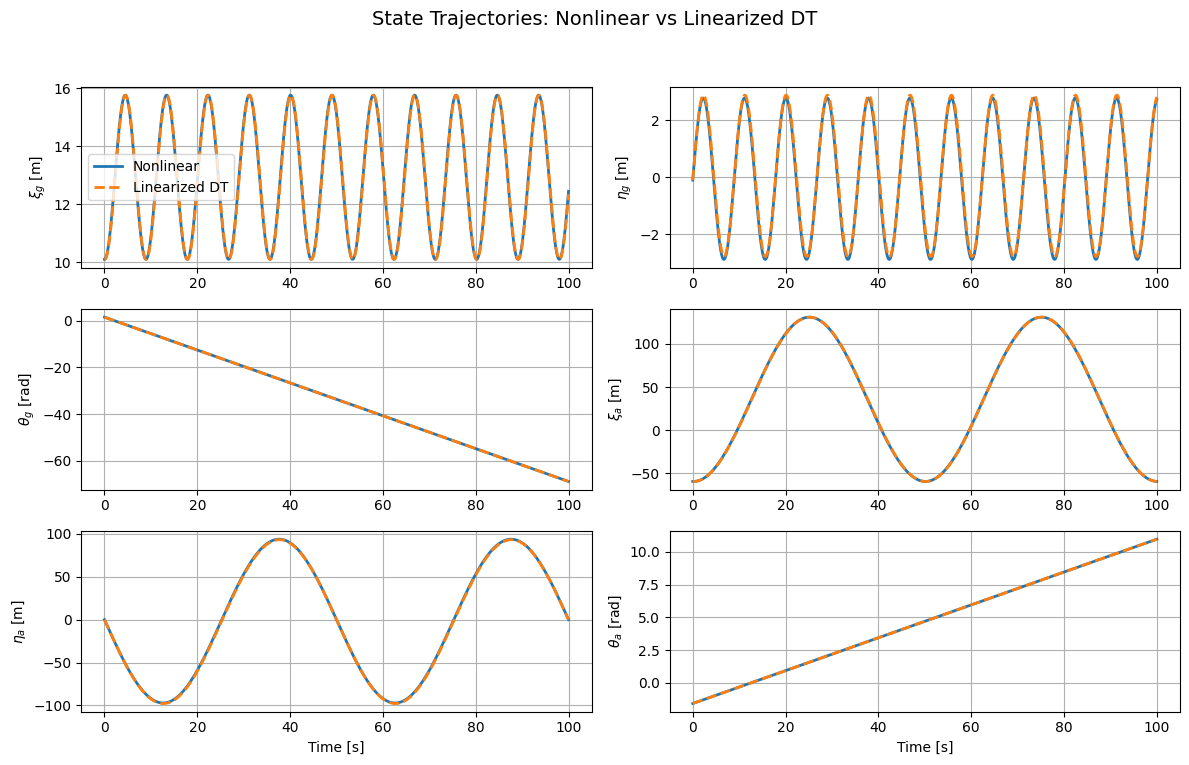

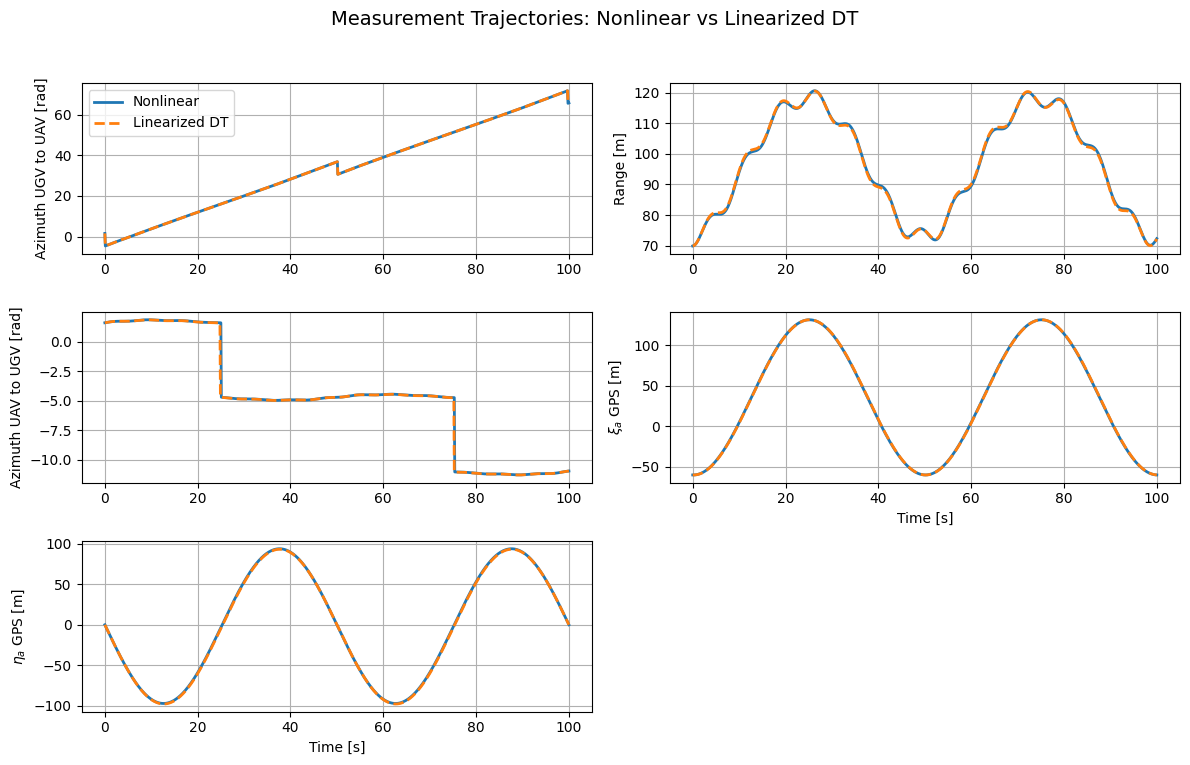

In [3]:
# ===================================
# Initial conditions and perturbation
# ===================================
data = loadmat("cooplocalization_finalproj_KFdata.mat")

# Keep things generalized
tvec = data["tvec"].ravel()
N_steps = tvec.size # 1001
dt = float(tvec[1] - tvec[0]) # 0.1 sec
t_span = (0.0, dt * (N_steps - 1)) # (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], N_steps)

# Randomly chosen initial perturbation
delta_x0 = np.array([
    0.1,                 # +0.1 m in xi_g
    -0.1,                # -0.1 m in eta_g
    np.deg2rad(1.0),     # +1 deg in theta_g
    0.2,                 # +0.2 m in xi_a
    0.0,                 # 0 m in eta_a
    np.deg2rad(-1.0)     # -1 deg in theta_a
])


# ===============================
# Nonlinear CT simulation (truth)
# ===============================
def ode_rhs(t, x_flat):
    return f_ct(x_flat, u_nom)

# Use solve_ivp to get DT solution
x0_nl = x_nom + delta_x0
nl_sim = solve_ivp(
    fun=ode_rhs,
    t_span=t_span,
    y0=x0_nl,
    t_eval=t_eval,
    rtol=1e-9,
    atol=1e-9
)
x_traj_nl = nl_sim.y.T # (N_steps, 6)
y_traj_nl = np.array([h_meas(x) for x in x_traj_nl]) # (N_steps, 5)


# ============================
# Nominal Nonlinear simulation
# ============================
x_traj_nom = np.zeros((N_steps, n)) # array of column vectors
x_traj_nom[0, :] = x_nom # no perturbation in nominal

# Using forward Euler to get DT results without linearizing
for k in range(N_steps - 1):
    x_traj_nom[k+1, :] = x_traj_nom[k, :] + dt * f_ct(x_traj_nom[k, :], u_nom)
y_traj_nom = np.array([h_meas(x) for x in x_traj_nom]) # Will be used in part 2


# ========================
# Linearized DT Simulation
# ========================
delta_x_lin = delta_x0.copy()

# Storage for state and measurement trajectories
x_traj_lin = np.zeros_like(x_traj_nom)
y_traj_lin = np.zeros_like(y_traj_nl)

# Precompute time-varying linearization (A_k, C_k, F_k, H_k)
F_list = []
H_list = []
C_list = []

# Loop through each nominal state, linearize, discretize, and evaluate
for k in range(N_steps):
    # Nominal state computed above
    x_nom_k = x_traj_nom[k, :]

    # Linearize around current nominal point
    A_k = np.array(A_eval(x_nom_k, u_nom, L_nom), dtype=float)
    B_k = np.array(B_eval(x_nom_k, u_nom, L_nom), dtype=float)
    C_k = np.array(C_eval(x_nom_k),               dtype=float)

    # Discretize to DT (time-varying F, G, H)
    F_k, G_k, H_k = discretize_ct_forward_euler(A_k, B_k, C_k, dt)

    # Save these for Part II
    F_list.append(F_k)
    H_list.append(H_k)
    C_list.append(C_k)
    
    # Total linearized state & measurement at this step
    x_traj_lin[k, :] = x_nom_k + delta_x_lin
    y_traj_lin[k, :] = y_traj_nom[k] + C_k @ delta_x_lin

    # Propagate perturbation (no input perturbation)
    if k < N_steps - 1:
        delta_x_lin = F_k @ delta_x_lin


# =========================
#       Plot results
# =========================
state_labels = [
    r"$\xi_g$ [m]",
    r"$\eta_g$ [m]",
    r"$\theta_g$ [rad]",
    r"$\xi_a$ [m]",
    r"$\eta_a$ [m]",
    r"$\theta_a$ [rad]",
]

fig1, axes1 = plt.subplots(3, 2, figsize=(12, 8))
axes1 = axes1.ravel()

for i in range(6):
    ax = axes1[i]
    ax.plot(t_eval, x_traj_nl[:, i], label="Nonlinear", linewidth=2)
    ax.plot(t_eval, x_traj_lin[:, i], "--", label="Linearized DT", linewidth=2)
    ax.set_ylabel(state_labels[i])
    ax.grid(True)
    if i == 0:
        ax.legend(loc="best")

axes1[-1].set_xlabel("Time [s]")
axes1[-2].set_xlabel("Time [s]")
fig1.suptitle("State Trajectories: Nonlinear vs Linearized DT", fontsize=14)
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])

meas_labels = [
    r"Azimuth UGV to UAV [rad]",
    r"Range [m]",
    r"Azimuth UAV to UGV [rad]",
    r"$\xi_a$ GPS [m]",
    r"$\eta_a$ GPS [m]",
]

fig2, axes2 = plt.subplots(3, 2, figsize=(12, 8))
axes2 = axes2.ravel()

for i in range(5):
    ax = axes2[i]
    ax.plot(t_eval, y_traj_nl[:, i], label="Nonlinear", linewidth=2)
    ax.plot(t_eval, y_traj_lin[:, i], "--", label="Linearized DT", linewidth=2)
    ax.set_ylabel(meas_labels[i])
    ax.grid(True)
    if i == 0:
        ax.legend(loc="best")

axes2[-1].axis("off")
axes2[-2].set_xlabel("Time [s]")
axes2[-3].set_xlabel("Time [s]")
fig2.suptitle("Measurement Trajectories: Nonlinear vs Linearized DT", fontsize=14)
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


The Linearized KF that is linearized around a nominal trajectory loops through the nominal trajectory values $x_{nom}$ and linearizes the dynamics around the current nominal state value $x_{nom}(k)$. This contrasts with the EKF, which linearizes around the current state estimate $x_k^+$

Now we are tasked with implementing a Kalman filter. Recall the equations we use for each prediction step: $$\hat{x}_{k+1}^-=F\hat{x}_k^++Gu_k$$ $$P_{k+1}^-=FP_k^+F^T+Q$$ $$K_{k+1}=P_{k+1}^-H_{k+1}^T[H_{k+1}P_{k+1}^-H_{k+1}^T+R]^{-1}$$ When a new measurement comes in we do $$\hat{x}_{k+1}^+=\hat{x}_{k+1}^-+K_{k+1}(y_{k+1}-H_{k+1}\hat{x}_{k+1}^-)$$ $$P_{k+1}^+=(I-K_{k+1}H_{k+1})P_{k+1}^-$$

Since we are doing perturbation mechanics here, all of our $x$ values in the equation above are now $\delta x$. For example in our LKF loop, one of the first things we do is $\delta \hat{x}_{k+1}^-=F_k\delta \hat{x}_k^++G_k\delta u_k$. Since we have no input/control pertubation, $\delta u_k$ is 0. So $\delta \hat{x}_{k+1}^-=F_k\delta \hat{x}_k^+$. Our measurement's also use the perturbation dynamics. The equation for $\hat{y}_{k+1}^-$ is $\hat{y}_{k+1}^-=y_{nom}(k) + H_k\delta \hat{x}_k^-$

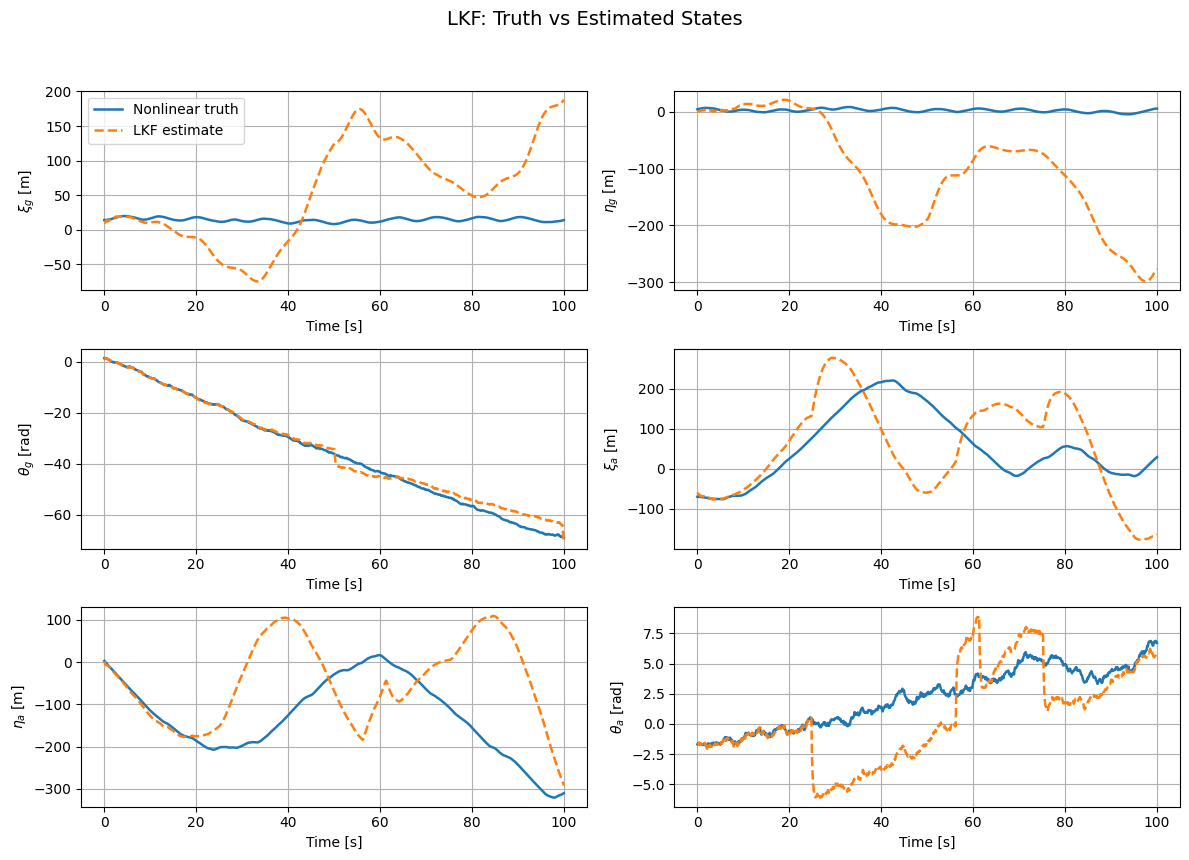

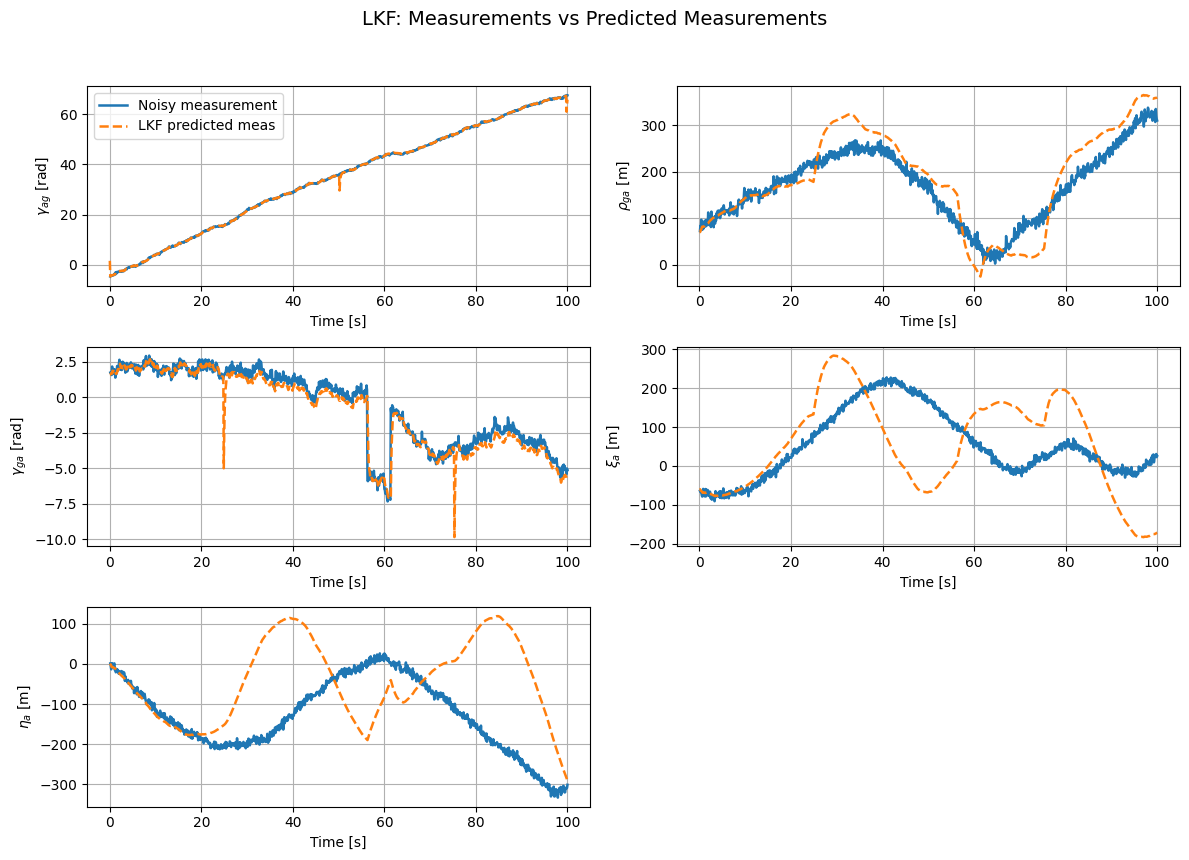

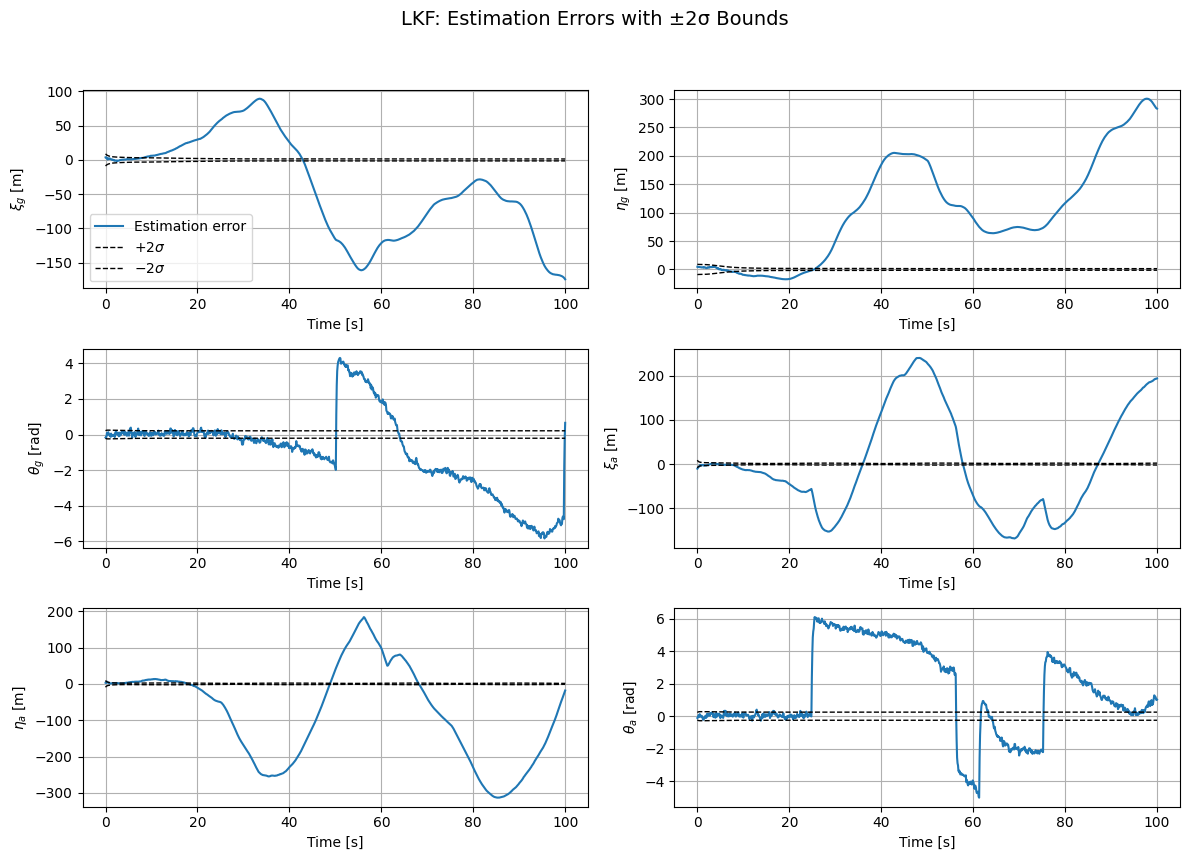

In [4]:
# =================
#   Initial Setup 
# =================

# Load the cov matrices from .mat data
Q_true = data["Qtrue"] # 6x6
R_true = data["Rtrue"] # 5x5

# Non global version of random.seed()
rng = np.random.default_rng(42)

# Filter's initial mean and cov - we are told to keep these the same for each run
# Will use them to generate a random ground truth x(0) on each run
delta_x0_mean = np.zeros(n)
P0_plus = np.diag([
    5.0,    # std dev in xi_g [m]
    5.0,    # std dev in eta_g [m]
    np.deg2rad(5.0),  # std dev in theta_g [rad]
    10.0,   # std dev in xi_a [m]
    10.0,   # std dev in eta_a [m]
    np.deg2rad(5.0)   # std dev in theta_a [rad]
])**2 # ^2 makes it variances


def simulate_truth_trajectory(
    Q, R,
    delta_x0_mean, P0_plus,
    x_traj_nom,     # only x_traj_nom[0] is used here
    u_nom, L_nom, dt,
    rng=None
):
    """
    Generate ONE nonlinear truth trajectory + noisy measurements for TMT.

    Returns:
      - x_true: (N_steps, n)
      - y_meas: (N_steps, p)
    """
    if rng is None:
        rng = np.random.default_rng()
    N_steps, n = x_traj_nom.shape
    p = R.shape[0]

    # ===============================================
    #     Truth simulation (nonlinear + noises)
    # ===============================================
    
    # Sample true initial perturbation and build true initial state
    delta_x0_true = rng.multivariate_normal(mean=delta_x0_mean, cov=P0_plus)
    x_true = np.zeros((N_steps, n))
    x_true[0, :] = x_traj_nom[0, :] + delta_x0_true
    w = rng.multivariate_normal(mean=np.zeros(n), cov=Q, size=N_steps)  # process noise
    for k in range(N_steps - 1):
        x_true[k+1, :] = x_true[k, :] + dt * f_ct(x_true[k, :], u_nom, L_nom) + w[k]
    
    # Simulate noisy measurements from nonlinear h(x) with R_true
    y_meas = np.zeros((N_steps, p))
    y_meas[0, :] = np.nan  # t=0 often unused / NaNs as in ydata
    v = rng.multivariate_normal(mean=np.zeros(p), cov=R, size=N_steps)  # measurement noise
    for k in range(1, N_steps):
        y_meas[k, :] = h_meas(x_true[k, :]) + v[k]

    return x_true, y_meas

    
def run_LKF_on_truth(
    Q_KF, R_KF,
    delta_x0_mean, P0_plus,
    x_traj_nom, y_traj_nom,
    F_list, H_list,
    x_true, y_meas
):
    """
    Run ONE truth-model test (TMT) + linearized KF pass.

    Returns a dict with everything needed for NEES/NIS and plotting:
      - x_true, y_meas: nonlinear truth state and noisy measurement trajectories
      - x_hat_hist: reconstructed full state estimates
      - e_hist: state estimation errors (x_true - x_hat)
      - P_hist: posterior covariances P_k^+
      - innov_hist: innovations ν_k
      - S_hist: innovation covariances S_k
      - y_pred_hist: predicted measurements from the filter
    """
    N_steps, n = x_traj_nom.shape
    p = R_true.shape[0]
    
    
    # ============================================
    #   Linearized KF around nominal trajectory
    # ============================================
    
    # Initial filter state in delta_x coordinates
    delta_x_hat_plus = delta_x0_mean.copy()  # filter's initial mean
    P_plus = P0_plus.copy()
    
    # Storage
    delta_x_hat_hist = np.zeros((N_steps, n))
    P_hist = np.zeros((N_steps, n, n))
    x_hat_hist = np.zeros((N_steps, n))
    y_pred_hist = np.zeros((N_steps, p))
    innov_hist = np.zeros((N_steps, p))
    S_hist = np.zeros((N_steps, p, p))
    
    for k in range(N_steps):
        x_nom_k = x_traj_nom[k, :]
        F_k = F_list[k]
        H_k = H_list[k]
        
        # Time update (predict)
        delta_x_hat_minus = F_k @ delta_x_hat_plus
        P_minus = F_k @ P_plus @ F_k.T + Q_KF
        S_k = H_k @ P_minus @ H_k.T + R_KF
        K_k = P_minus @ H_k.T @ np.linalg.inv(S_k)
        
        # Get innovation term
        y_meas_k = y_meas[k, :]
        y_pred_k = y_traj_nom[k] + H_k @ delta_x_hat_minus
        innov_k = np.zeros(p) if k == 0 else y_meas_k - y_pred_k    # t=0 data is NaNs
        
        # Measurement update (KF)
        delta_x_hat_plus = delta_x_hat_minus + K_k @ innov_k
        P_plus = (np.eye(n) - K_k @ H_k) @ P_minus
    
        # Reconstruct full state estimate
        x_hat_k = x_nom_k + delta_x_hat_plus
    
        # Log everything
        delta_x_hat_hist[k, :] = delta_x_hat_plus
        P_hist[k, :, :] = P_plus
        x_hat_hist[k, :] = x_hat_k
        y_pred_hist[k, :] = y_pred_k
        innov_hist[k, :] = innov_k
        S_hist[k, :, :] = S_k
    
    # Save state estimation errors
    e_hist = x_true - x_hat_hist  # shape (N_steps, 6)
    sigma_hist = np.sqrt(np.stack([np.diag(P_hist[k, :, :]) for k in range(N_steps)], axis=0))  # (N_steps, 6)

    return {
        "x_hat_hist": x_hat_hist,
        "e_hist": e_hist,
        "P_hist": P_hist,
        "sigma_hist": sigma_hist,
        "y_pred_hist": y_pred_hist,
        "innov_hist": innov_hist,
        "S_hist": S_hist,
    }


# ================
#   4(a) - Single Run
# ================
# Start with truth, will tune later
Q_KF = Q_true.copy()  
R_KF = R_true.copy()

# Get Truth
x_true, y_meas = simulate_truth_trajectory(
    Q=Q_true,
    R=R_true,
    delta_x0_mean=delta_x0_mean,
    P0_plus=P0_plus,
    x_traj_nom=x_traj_nom,
    u_nom=u_nom,
    L_nom=L_nom,
    dt=dt,
    rng=rng
)

# Run the LKF
result = run_LKF_on_truth(
    Q_KF=Q_KF, R_KF=R_KF,
    delta_x0_mean=delta_x0_mean,
    P0_plus=P0_plus,
    x_traj_nom=x_traj_nom,
    y_traj_nom=y_traj_nom,
    F_list=F_list,
    H_list=H_list,
    x_true=x_true,
    y_meas=y_meas
)

x_hat_hist = result["x_hat_hist"]
y_pred_hist = result["y_pred_hist"]
sigma_hist = result["sigma_hist"]
e_hist = result["e_hist"]



def plot_single_run_results(
    tvec,
    x_true,
    y_meas,
    x_hat_hist,
    y_pred_hist,
    e_hist,
    sigma_hist,
    state_labels,
    meas_labels,
    filter_name="KF",
    save_prefix=None
):
    """
    Shared plotting for Parts 4(a) and 5(a).
    
    Produces three figures:
      1. Truth vs estimate (states)
      2. Noisy measurement vs predicted measurement
      3. State estimation errors with +/- 2 sigma bounds

    If save_prefix is provided, files are saved as:
        f"{save_prefix}_states.png"
        f"{save_prefix}_measurements.png"
        f"{save_prefix}_errors.png"
    """

    n = x_true.shape[1]
    p = y_meas.shape[1]
    
    state_labels = [
        r"$\xi_g$ [m]",
        r"$\eta_g$ [m]",
        r"$\theta_g$ [rad]",
        r"$\xi_a$ [m]",
        r"$\eta_a$ [m]",
        r"$\theta_a$ [rad]",
    ]
    
    # Writing this manually since the format given in .mat file doesnt work with python
    meas_labels = [
        r"$\gamma_{ag}$ [rad]",
        r"$\rho_{ga}$ [m]",
        r"$\gamma_{ga}$ [rad]",
        r"$\xi_a$ [m]",
        r"$\eta_a$ [m]",
    ]
    
    # State Trajectories
    fig1, axes1 = plt.subplots(3, 2, figsize=(12, 9))
    axes1 = axes1.ravel()

    for i in range(n):
        ax = axes1[i]
        ax.plot(tvec, x_true[:, i], label="Nonlinear truth", linewidth=1.8)
        ax.plot(tvec, x_hat_hist[:, i], "--", label=f"{filter_name} estimate", linewidth=1.8)
        ax.set_ylabel(state_labels[i])
        ax.set_xlabel("Time [s]")
        ax.grid(True)
        if i == 0:
            ax.legend(loc="best")

    fig1.suptitle(f"{filter_name}: Truth vs Estimated States", fontsize=14)
    fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if save_prefix is not None:
        fig1.savefig(f"{save_prefix}_states.png")

    # Measuements
    fig2, axes2 = plt.subplots(3, 2, figsize=(12, 9))
    axes2 = axes2.ravel()

    for i in range(p):
        ax = axes2[i]
        ax.plot(tvec, y_meas[:, i], label="Noisy measurement", linewidth=1.8)
        ax.plot(tvec, y_pred_hist[:, i], "--", label=f"{filter_name} predicted meas", linewidth=1.8)
        ax.set_ylabel(meas_labels[i])
        ax.set_xlabel("Time [s]")
        ax.grid(True)
        if i == 0:
            ax.legend(loc="best")

    axes2[-1].axis("off")

    fig2.suptitle(f"{filter_name}: Measurements vs Predicted Measurements", fontsize=14)
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if save_prefix is not None:
        fig2.savefig(f"{save_prefix}_measurements.png")

    # State Estimation Error +2 sigma
    fig3, axes3 = plt.subplots(3, 2, figsize=(12, 9))
    axes3 = axes3.ravel()

    for i in range(n):
        ax = axes3[i]
        ax.plot(tvec, e_hist[:, i], label="Estimation error", linewidth=1.5)
        ax.plot(tvec,  2.0 * sigma_hist[:, i], "k--", label=r"$+2\sigma$", linewidth=1.0)
        ax.plot(tvec, -2.0 * sigma_hist[:, i], "k--", label=r"$-2\sigma$", linewidth=1.0)
        ax.set_ylabel(state_labels[i])
        ax.set_xlabel("Time [s]")
        ax.grid(True)
        if i == 0:
            ax.legend(loc="best")

    fig3.suptitle(rf"{filter_name}: Estimation Errors with $\pm2\sigma$ Bounds (Single Run)", fontsize=14)
    fig3.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if save_prefix is not None:
        fig3.savefig(f"{save_prefix}_errors.png")

    plt.show()
    
plot_single_run_results(
    tvec=tvec,
    x_true=x_true,
    y_meas=y_meas,
    x_hat_hist=x_hat_hist,
    y_pred_hist=y_pred_hist,
    e_hist=e_hist,
    sigma_hist=sigma_hist,
    state_labels=state_labels,
    meas_labels=meas_labels,
    filter_name="LKF",
    save_prefix="4a_LKF"
)


# 4 part (b) and (c) - LKF NEES and NIS

NEES (LKF) mean bounds at 95.0% CI:
  lower: 5.529, upper: 6.489
  expected mean = dof = 6


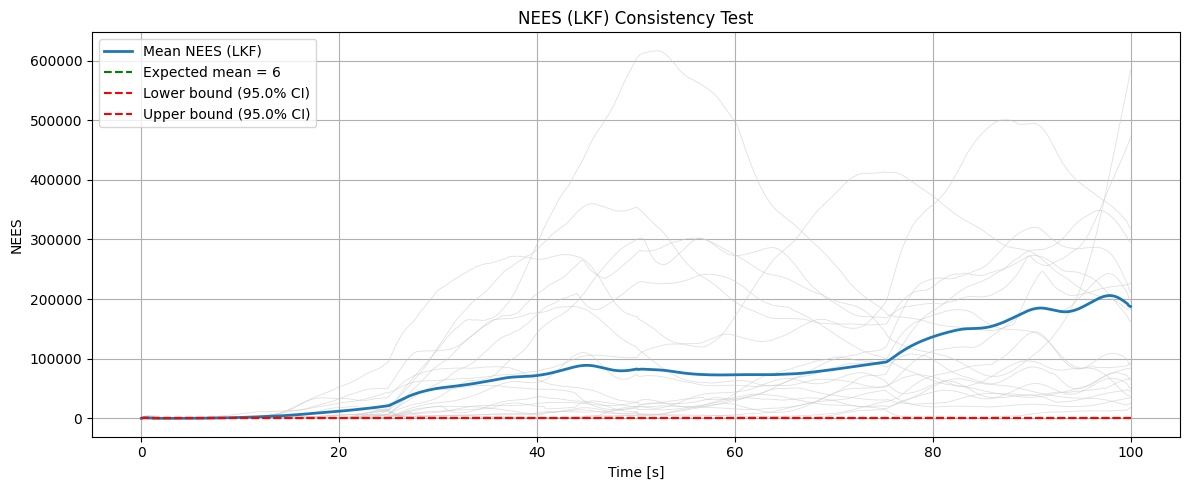

NIS (LKF) mean bounds at 95.0% CI:
  lower: 4.571, upper: 5.448
  expected mean = dof = 5


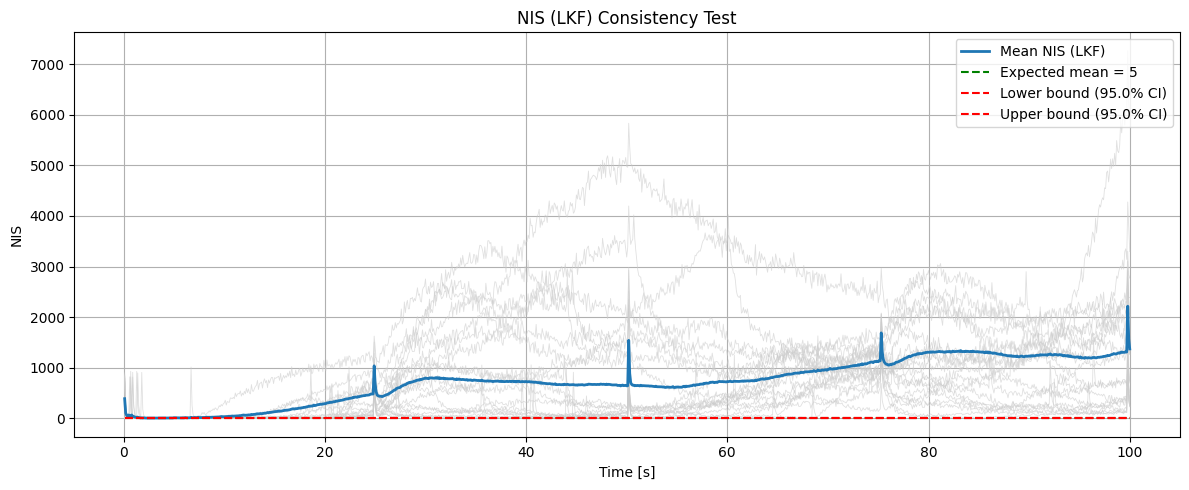

In [5]:
from scipy.stats import chi2

def run_mc_TMT(
    filter_runner,      # run_LKF_on_truth or run_EKF_on_truth
    Q_true, R_true,
    Q_KF, R_KF,
    delta_x0_mean, P0_plus,
    x_traj_nom, y_traj_nom,
    F_list, H_list,    # only used by LKF; EKF can ignore via wrapper
    u_nom, L_nom, dt,
    N_mc, alpha, rng
):
    """ 
    Run Monte Carlo Truth Model Tests
    Returns NEES and NIS data. 
    filter_runner can either be the LKF or EKF function
    """
    
    N_steps, n = x_traj_nom.shape
    p = R_true.shape[0]

    NEES = np.zeros((N_mc, N_steps))
    NIS  = np.zeros((N_mc, N_steps))

    for i in range(N_mc):
        # Get truth
        x_true, y_meas = simulate_truth_trajectory(
            Q=Q_true,
            R=R_true,
            delta_x0_mean=delta_x0_mean,
            P0_plus=P0_plus,
            x_traj_nom=x_traj_nom,
            u_nom=u_nom,
            L_nom=L_nom,
            dt=dt,
            rng=rng
        )

        # Run chosen filter on this truth
        if filter_runner is run_LKF_on_truth:
            result = filter_runner(
                Q_KF=Q_KF, R_KF=R_KF,
                delta_x0_mean=delta_x0_mean,
                P0_plus=P0_plus,
                x_traj_nom=x_traj_nom,
                y_traj_nom=y_traj_nom,
                F_list=F_list,
                H_list=H_list,
                x_true=x_true,
                y_meas=y_meas
            )
        else:
            result = filter_runner(
                Q_KF=Q_KF, R_KF=R_KF,
                delta_x0_mean=delta_x0_mean,
                P0_plus=P0_plus,
                x_traj_nom=x_traj_nom,
                u_nom=u_nom,
                L_nom=L_nom,
                x_true=x_true,
                y_meas=y_meas,
                dt=dt
            )

        e_hist     = result["e_hist"]
        P_hist     = result["P_hist"]
        innov_hist = result["innov_hist"]
        S_hist     = result["S_hist"]

        # NEES
        for k in range(N_steps):
            e_k = e_hist[k, :]
            P_k = P_hist[k, :, :]
            NEES[i, k] = e_k @ np.linalg.solve(P_k, e_k)

        # NIS (skip k=0)
        for k in range(1, N_steps):
            innov_k = innov_hist[k, :]
            S_k = S_hist[k, :, :]
            NIS[i, k] = innov_k @ np.linalg.solve(S_k, innov_k)

    return NEES, NIS


def plot_consistency_stat(
    tvec_plot,
    samples,          # shape (N_mc, N_steps_plot)
    dof,              # n for NEES, p for NIS
    alpha,
    quantity_name,    # e.g. "NEES (LKF)" or "NIS (EKF)"
    ylabel,           # e.g. "NEES" or "NIS"
    legend_loc="upper left"
):
    """
    Plot consistency statistic (NEES or NIS) vs time with chi-square bounds.

    tvec_plot : (N_steps_plot,) time array
    samples   : (N_mc, N_steps_plot) array of per-run stats
    dof       : degrees of freedom (n for NEES, p for NIS)
    alpha     : significance level (e.g. 0.05 for 95% CI)
    """
    N_mc, N_steps_plot = samples.shape

    # Sample mean over Monte Carlo runs
    stat_mean = np.mean(samples, axis=0)

    # Chi-square bounds for the mean
    df_total = N_mc * dof
    lower_bound = chi2.ppf(alpha / 2.0, df=df_total) / N_mc
    upper_bound = chi2.ppf(1.0 - alpha / 2.0, df=df_total) / N_mc

    print(f"{quantity_name} mean bounds at {100*(1-alpha):.1f}% CI:")
    print(f"  lower: {lower_bound:.3f}, upper: {upper_bound:.3f}")
    print(f"  expected mean = dof = {dof}")

    # ------------------- Plot -------------------
    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot a few transparent trajectories to show spread
    for i in range(min(N_mc, 20)):
        ax.plot(tvec_plot, samples[i, :], color="0.8", linewidth=0.6, alpha=0.6)

    # Plot mean across MC runs
    ax.plot(tvec_plot, stat_mean, label=f"Mean {quantity_name}", linewidth=2)

    # Expected value and bounds
    ax.hlines(dof, tvec_plot[0], tvec_plot[-1],
              colors="g", linestyles="--",
              label=f"Expected mean = {dof}")
    ax.hlines(lower_bound, tvec_plot[0], tvec_plot[-1],
              colors="r", linestyles="--",
              label=f"Lower bound ({100*(1-alpha):.1f}% CI)")
    ax.hlines(upper_bound, tvec_plot[0], tvec_plot[-1],
              colors="r", linestyles="--",
              label=f"Upper bound ({100*(1-alpha):.1f}% CI)")

    ax.set_xlabel("Time [s]")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{quantity_name} Consistency Test")
    ax.grid(True)
    ax.legend(loc=legend_loc)

    plt.tight_layout()
    plt.show()

    
# ===========================
#     Run LKF Simulation
# ===========================
# Monte Carlo parameters
N_mc = 200 # number of Monte Carlo runs
alpha = 0.05 # significance level for 95% confidence interval

# Choose noise matrices - can be tuned
Q_KF = Q_true.copy()
R_KF = R_true.copy()

# Reproducible results while still having each trial be different
rng = np.random.default_rng(123)
NEES_LKF, NIS_LKF = run_mc_TMT(
    filter_runner=run_LKF_on_truth,
    Q_true=Q_true, R_true=R_true,
    Q_KF=Q_KF, R_KF=R_KF,
    delta_x0_mean=delta_x0_mean, P0_plus=P0_plus,
    x_traj_nom=x_traj_nom, y_traj_nom=y_traj_nom,
    F_list=F_list, H_list=H_list,
    u_nom=u_nom, L_nom=L_nom, dt=dt,
    N_mc=N_mc, alpha=alpha, rng=rng
)

# =====================
#   Plot LKF Results
# =====================

# NEES
plot_consistency_stat(
    tvec_plot=tvec,
    samples=NEES_LKF,
    dof=n,
    alpha=alpha,
    quantity_name="NEES (LKF)",
    ylabel="NEES",
    legend_loc="upper left",
)

# NIS - skip 0
plot_consistency_stat(
    tvec_plot=tvec[1:],
    samples=NIS_LKF[:, 1:],
    dof=p,
    alpha=alpha,
    quantity_name="NIS (LKF)",
    ylabel="NIS",
    legend_loc="upper right",
)


Issues:
- Nonlinear truth vs linearized filter about a noise-free nominal trajectory
- Process noise strong enough that x_true drifts far from x_traj_nom

# Question 5 - EKF

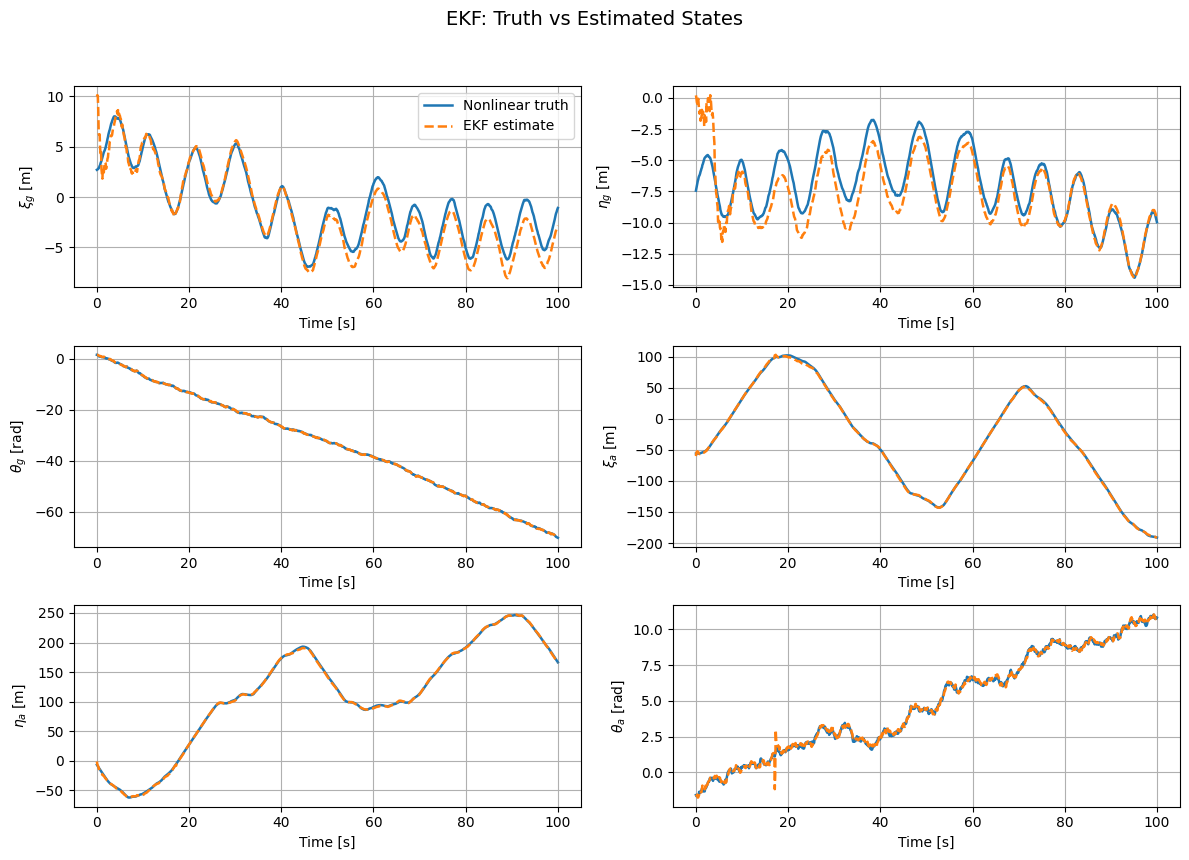

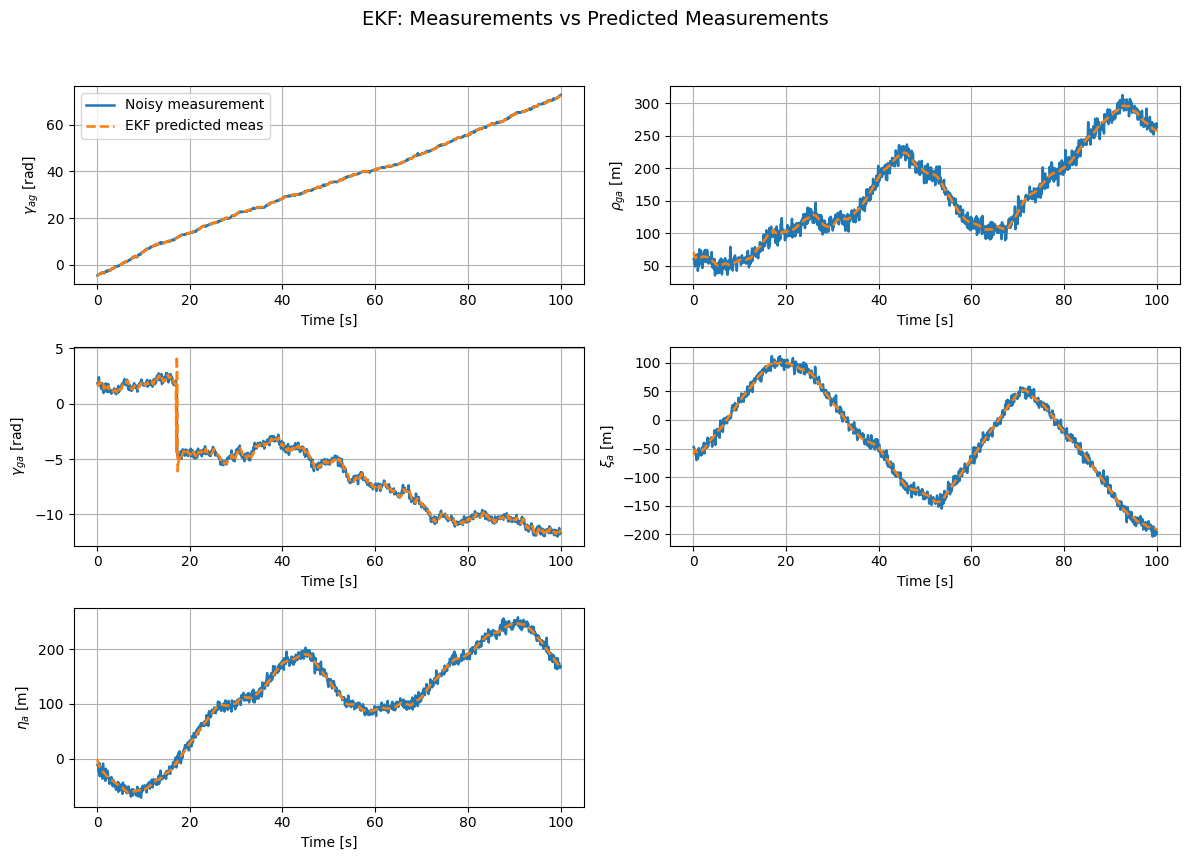

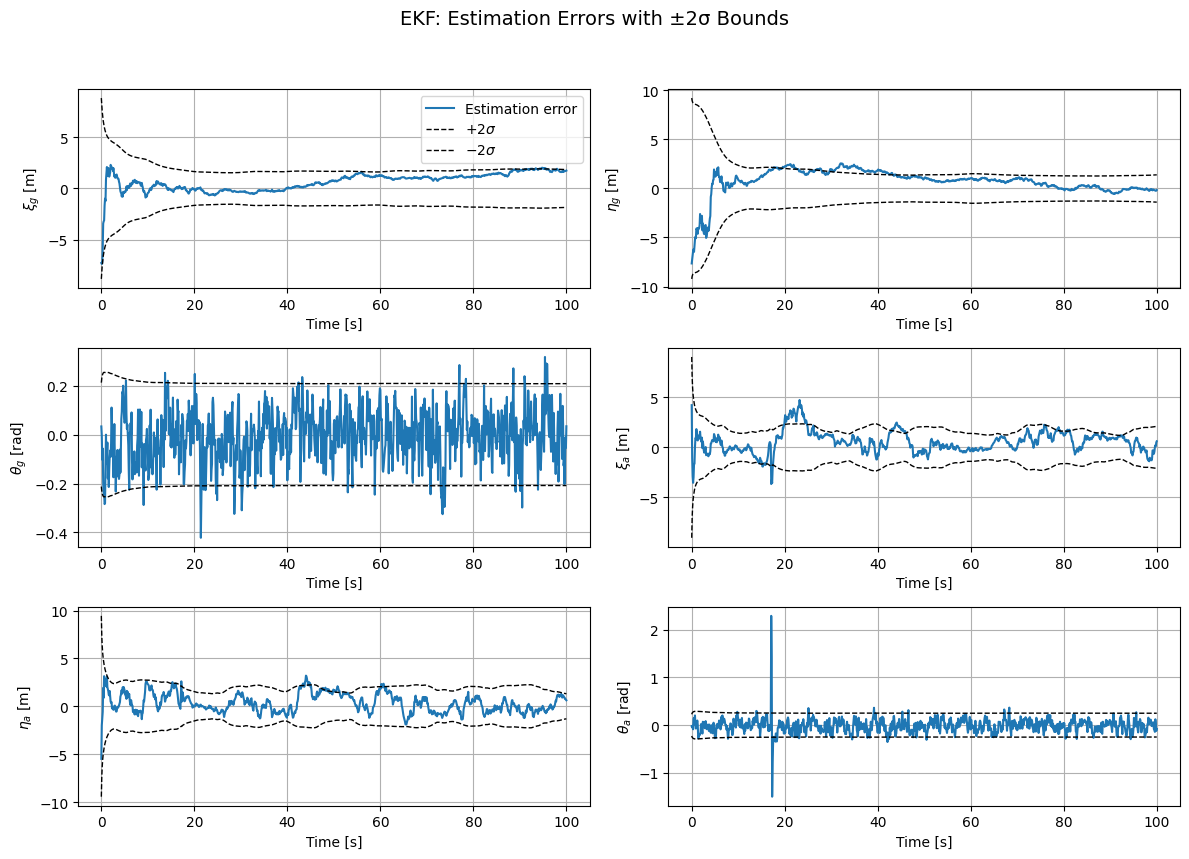

NEES (EKF) mean bounds at 95.0% CI:
  lower: 5.529, upper: 6.489
  expected mean = dof = 6


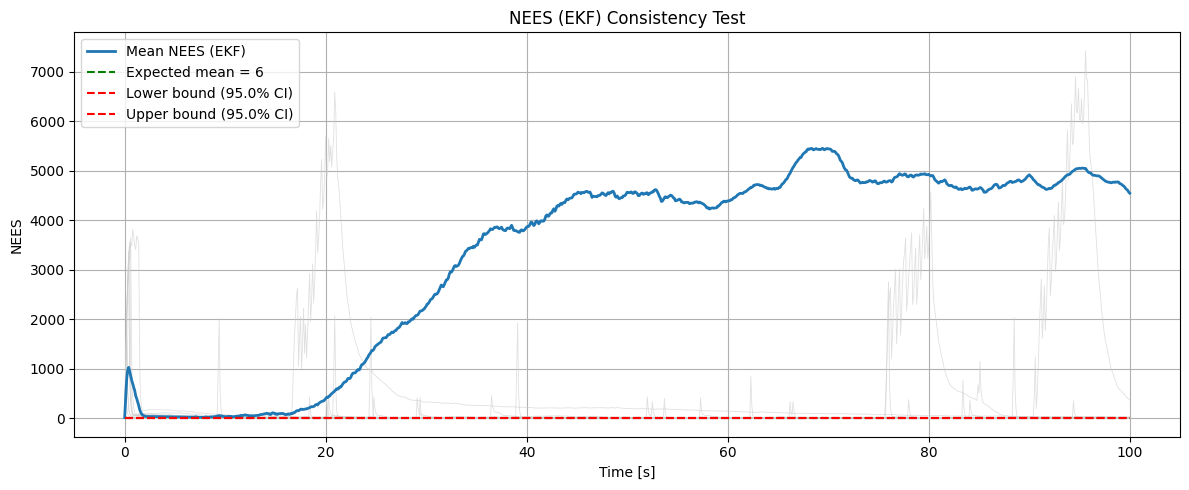

NIS (EKF) mean bounds at 95.0% CI:
  lower: 4.571, upper: 5.448
  expected mean = dof = 5


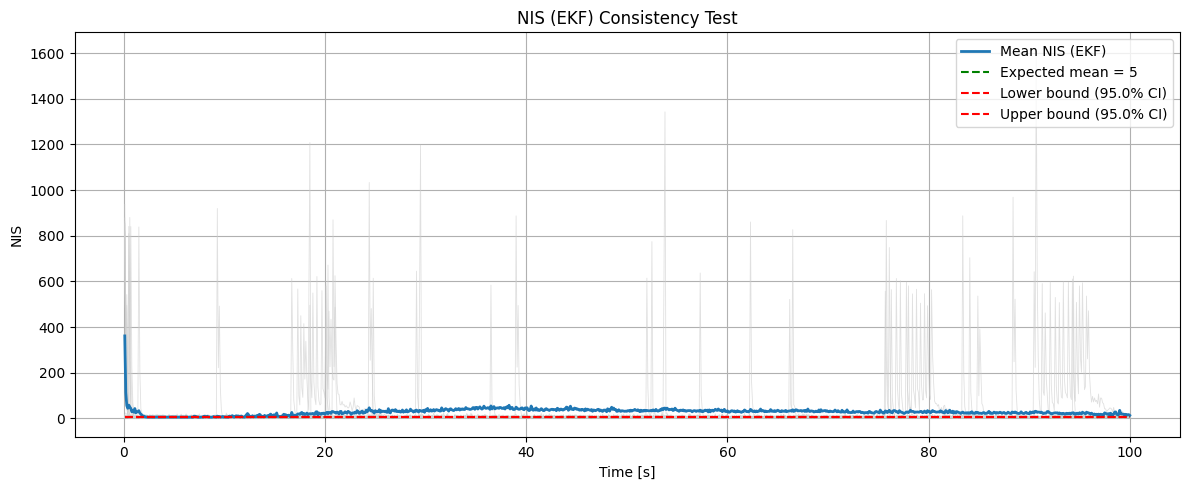

In [6]:
def run_EKF_on_truth(
    Q_KF, R_KF,
    delta_x0_mean, P0_plus,
    x_traj_nom,
    u_nom, L_nom,
    x_true, y_meas,
    dt
):
    """
    Run ONE EKF pass on a given truth trajectory and measurements.
    Same return structure as run_LKF_on_truth.
    """
    N_steps, n = x_traj_nom.shape
    p = R_KF.shape[0]

    # Initial filter state: nominal + mean perturbation
    x_hat_plus = x_traj_nom[0, :] + delta_x0_mean
    P_plus = P0_plus.copy()

    # Storage
    x_hat_hist = np.zeros((N_steps, n))
    P_hist = np.zeros((N_steps, n, n))
    y_pred_hist = np.zeros((N_steps, p))
    innov_hist = np.zeros((N_steps, p))
    S_hist = np.zeros((N_steps, p, p))

    # Initial conditions
    x_hat_hist[0, :] = x_hat_plus
    P_hist[0, :, :] = P_plus
    y_pred_hist[0, :] = np.nan
    innov_hist[0, :] = np.zeros(p)
    S_hist[0, :, :] = np.eye(p)

    for k in range(N_steps):
        # Time update (predict)
        x_hat_minus = x_hat_plus + dt * f_ct(x_hat_plus, u_nom, L_nom)
        # Get matrices for current iteration
        F_k = np.eye(n) + dt * np.array(A_eval(x_hat_plus, u_nom, L_nom), dtype=float)
        H_k = C_k = np.array(C_eval(x_hat_minus), dtype=float)
        # Continue prediction step
        P_minus = F_k @ P_plus @ F_k.T + Q_KF
        S_k = H_k @ P_minus @ H_k.T + R_KF
        K_k = P_minus @ H_k.T @ np.linalg.inv(S_k)

        # Get innovation term
        y_meas_k = y_meas[k, :]
        y_pred_k = h_meas(x_hat_minus)    # EKF uses estimate instead of nominal
        innov_k = np.zeros(p) if k == 0 else y_meas_k - y_pred_k    # t=0 data is NaNs

        # Measurement update
        x_hat_plus = x_hat_minus + K_k @ innov_k
        P_plus = (np.eye(n) - K_k @ H_k) @ P_minus

        # Log everything
        x_hat_hist[k, :] = x_hat_plus
        P_hist[k, :, :] = P_plus
        y_pred_hist[k, :] = y_pred_k
        innov_hist[k, :] = innov_k
        S_hist[k, :, :] = S_k

    # Errors and sigmas
    e_hist = x_true - x_hat_hist
    sigma_hist = np.sqrt(np.stack([np.diag(P_hist[k, :, :]) for k in range(N_steps)], axis=0))

    return {
        "x_hat_hist": x_hat_hist,
        "e_hist": e_hist,
        "P_hist": P_hist,
        "sigma_hist": sigma_hist,
        "y_pred_hist": y_pred_hist,
        "innov_hist": innov_hist,
        "S_hist": S_hist,
    }


# ============================
# Part 5 (a) - Single-run TMT
# ============================

# You can reuse the same Q_KF, R_KF, delta_x0_mean, P0_plus as LKF
Q_KF_EKF = Q_true.copy()
R_KF_EKF = R_true.copy()

# New RNG for this section (optional, just to decouple from LKF run)
rng_ekf = np.random.default_rng(321)

# Generate one nonlinear truth trajectory + noisy measurements
x_true_ekf, y_meas_ekf = simulate_truth_trajectory(
    Q=Q_true,
    R=R_true,
    delta_x0_mean=delta_x0_mean,
    P0_plus=P0_plus,
    x_traj_nom=x_traj_nom,
    u_nom=u_nom,
    L_nom=L_nom,
    dt=dt,
    rng=rng_ekf
)

# Run EKF on this truth
result_EKF = run_EKF_on_truth(
    Q_KF=Q_KF_EKF, R_KF=R_KF_EKF,
    delta_x0_mean=delta_x0_mean,
    P0_plus=P0_plus,
    x_traj_nom=x_traj_nom,
    u_nom=u_nom,
    L_nom=L_nom,
    x_true=x_true_ekf,
    y_meas=y_meas_ekf,
    dt=dt
)

x_hat_hist_ekf  = result_EKF["x_hat_hist"]
y_pred_hist_ekf = result_EKF["y_pred_hist"]
sigma_hist_ekf  = result_EKF["sigma_hist"]
e_hist_ekf      = result_EKF["e_hist"]      # (N_steps, n)

plot_single_run_results(
    tvec=tvec,
    x_true=x_true_ekf,
    y_meas=y_meas_ekf,
    x_hat_hist=result_EKF["x_hat_hist"],
    y_pred_hist=result_EKF["y_pred_hist"],
    e_hist=result_EKF["e_hist"],
    sigma_hist=result_EKF["sigma_hist"],
    state_labels=state_labels,
    meas_labels=meas_labels,
    filter_name="EKF",
    save_prefix="5a_EKF"
)



# ============================
# 5 (b) and (c) - NEES and NIS
# ============================
NEES_EKF, NIS_EKF = run_mc_TMT(
    filter_runner=run_EKF_on_truth,
    Q_true=Q_true, R_true=R_true,
    Q_KF=Q_KF, R_KF=R_KF,
    delta_x0_mean=delta_x0_mean, P0_plus=P0_plus,
    x_traj_nom=x_traj_nom, y_traj_nom=y_traj_nom,
    F_list=F_list, H_list=H_list,
    u_nom=u_nom, L_nom=L_nom, dt=dt,
    N_mc=N_mc, alpha=alpha, rng=rng
)

plot_consistency_stat(
    tvec_plot=tvec,
    samples=NEES_EKF,
    dof=n,
    alpha=alpha,
    quantity_name="NEES (EKF)",
    ylabel="NEES",
    legend_loc="upper left",
)

plot_consistency_stat(
    tvec_plot=tvec[1:],
    samples=NIS_EKF[:, 1:],
    dof=p,
    alpha=alpha,
    quantity_name="NIS (EKF)",
    ylabel="NIS",
    legend_loc="upper right",
)